# Classification of fixed size paragraph vectors using LSTM
should be able to deal with all levels using the PARTS_LEVEL param

In [1]:
import json
import nltk
from nltk.tokenize import RegexpTokenizer
import string
import math
import os
import time
from collections import namedtuple, defaultdict
import cPickle as pickle
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import random

from multiprocessing.dummy import Pool as ThreadPool
import itertools

from sklearn.metrics import coverage_error
import sklearn.metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn import linear_model
from sklearn.preprocessing import MultiLabelBinarizer

from gensim.models.doc2vec import Doc2Vec, LabeledSentence

import logging
from logging import info
from functools import partial

import seaborn

import keras
from keras.layers import Input, Dense, Dropout, Masking
from keras.models import Model, Sequential
from keras.layers import Input, Masking
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.convolutional import MaxPooling1D, Convolution1D
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.recurrent import LSTM

from sklearn.model_selection import ParameterSampler

from thesis.utils.metrics import *

Using gpu device 0: TITAN X (Pascal) (CNMeM is disabled, cuDNN 5105)
/home/stud/shalaby/.virtualenv/thesis-env/local/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


# Global variables used throughout the script

In [2]:
root = logging.getLogger()
for handler in root.handlers[:]:
    root.removeHandler(handler)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO) # adds a default StreamHanlder
#root.addHandler(logging.StreamHandler())

In [3]:
SVM_SEED = 1234
DOC2VEC_SEED = 1234
WORD2VEC_SEED = 1234
NN_SEED = 1234

In [4]:
NUM_CORES = 16

In [5]:
GLOBAL_VARS = namedtuple('GLOBAL_VARS', ['MODEL_NAME', 'DOC2VEC_MODEL_NAME', 'DOC2VEC_MODEL', 
                                         'SVM_MODEL_NAME', 'NN_MODEL_NAME'])

In [6]:
VOCAB_MODEL = "vocab_model"
MODEL_PREFIX = "model"
VALIDATION_MATRIX = "validation_matrix.pkl"
VALIDATION_DICT = "validation_dict.pkl"
TEST_MATRIX = "test_matrix.pkl"
TEST_DICT = "test_dict.pkl"
METRICS = "metrics.pkl"
CLASSIFIER = "classifier.pkl"
TYPE_CLASSIFIER= "{}_classifier.pkl"

TRAINING_DATA_MATRIX = "X_level_{}.npy"
TRAINING_LABELS_MATRIX = "y_{}.npy"
VALIDATION_DATA_MATRIX = "Xv_level_{}.npy"
VALIDATION_LABELS_MATRIX = "yv_{}.npy"

In [7]:
NN_PARAMETER_SEARCH_PREFIX = "lstm_{}_level_{}_batch_{}_nn_parameter_searches.pkl"

In [8]:
SAMPLE_RATIO = 0.15

In [9]:
root_location = "/mnt/data2/shalaby/"
big_data_location = "/mnt/data/shalaby/"

doc_vec_types = "extended_abs_desc_claims_large_sample_chunks"
doc_vec_preprocessed_data_types = "extended_pv_abs_desc_claims_large_sample_chunks"

exports_location = root_location + "exported_data/"

doc2vec_model_save_location = os.path.join(big_data_location, "parameter_search_doc2vec_models_" + doc_vec_types, "full")
nn_parameter_search_location = os.path.join(root_location, "nn_parameter_search_" + doc_vec_types)
if not os.path.exists(doc2vec_model_save_location):
    os.makedirs(doc2vec_model_save_location)
if not os.path.exists(os.path.join(doc2vec_model_save_location, VOCAB_MODEL)):
    os.makedirs(os.path.join(doc2vec_model_save_location, VOCAB_MODEL))

#training_file = root_location + "docs_output.json"
training_file = root_location + 'docs_output.json'

doc_classifications_map_file = exports_location + "doc_classification_map.pkl"
sections_file = exports_location + "sections.pkl"
classes_file = exports_location + "classes.pkl"
subclasses_file = exports_location + "subclasses.pkl"
valid_classes_file = exports_location + "valid_classes.pkl"
valid_subclasses_file = exports_location + "valid_subclasses.pkl"
classifications_output = exports_location + "classifications.pkl"
# training_docs_list_file = exports_location + "extended_pv_training_docs_list.pkl"
# validation_docs_list_file = exports_location + "extended_pv_validation_docs_list.pkl"
# test_docs_list_file = exports_location + "extended_pv_test_docs_list.pkl"
training_docs_list_file = exports_location + "extended_pv_training_docs_list_" + str(SAMPLE_RATIO) + ".pkl"
validation_docs_list_file = exports_location + "extended_pv_validation_docs_list_" + str(SAMPLE_RATIO) + ".pkl"
test_docs_list_file = exports_location + "extended_pv_test_docs_list_" + str(SAMPLE_RATIO) + ".pkl"

preprocessed_location = os.path.join(big_data_location, "preprocessed_data", doc_vec_preprocessed_data_types) + "/"

training_preprocessed_files_prefix = preprocessed_location + "extended_pv_training_docs_data_preprocessed-"
validation_preprocessed_files_prefix = preprocessed_location + "extended_pv_validation_docs_data_preprocessed-"
test_preprocessed_files_prefix = preprocessed_location + "extended_pv_test_docs_data_preprocessed-"

word2vec_questions_file = result = root_location + 'tensorflow/word2vec/questions-words.txt'

# Load general data required for classification

In [10]:
%%time
doc_classification_map = pickle.load(open(doc_classifications_map_file))
sections = pickle.load(open(sections_file))
classes = pickle.load(open(classes_file))
subclasses = pickle.load(open(subclasses_file))
valid_classes = pickle.load(open(valid_classes_file))
valid_subclasses = pickle.load(open(valid_subclasses_file))
training_docs_list = pickle.load(open(training_docs_list_file))
validation_docs_list = pickle.load(open(validation_docs_list_file))
test_docs_list = pickle.load(open(test_docs_list_file))

CPU times: user 20.1 s, sys: 2.18 s, total: 22.2 s
Wall time: 22.3 s


In [11]:
len(training_docs_list)

254767

In [12]:
len(validation_docs_list)

60957

In [13]:
len(test_docs_list)

79785

# Utility Functions for data loading

In [14]:
class OneHotEncoder():
    
    def __init__(self, classifications):
        self.classifications = classifications
        self.one_hot_indices = {}

        # convert character classifications to bit vectors
        for i, clssf in enumerate(classifications):
            bits = [0] * len(classifications)
            bits[i] = 1
            self.one_hot_indices[clssf] = i
    
    def get_label_vector(self, labels):
        """
        classes: array of string with the classes assigned to the instance
        """
        output_vector = [0] * len(self.classifications)
        for label in labels:
            index = self.one_hot_indices[label]
            output_vector[index] = 1
            
        return output_vector
    
def ensure_disk_location_exists(location):
    if not os.path.exists(location):
        os.makedirs(location)

In [15]:
class FixedDocumentsStatsGenerator(object):
    def __init__(self, filename_prefix):
        self.filename_prefix = filename_prefix
        self.docids = []
        self.doc_parts = defaultdict(list)
        self.doc_part_chunks = defaultdict(list)
        self.curr_doc_index = 0
        self.batch_end = -1
    def load_new_batch_in_memory(self):
        info("Loading new batch for index: {}".format(self.curr_doc_index))
        true_docs_count = 0
        try:
            with open(self.filename_prefix + str(self.curr_doc_index)) as preproc_file:
                for line in preproc_file:
                    line_array = line.split(" ", 1)
                    entity_id = line_array[0].strip()
                    if self.is_doc(entity_id):
                        self.docids.append(entity_id)
                        true_docs_count+= 1
                    elif self.is_doc_part(entity_id):
                        self.doc_parts[self.get_doc_id(entity_id)].append(entity_id)
                    elif self.is_doc_part_chunk(entity_id):
                        self.doc_part_chunks[self.get_doc_id(entity_id)].append(entity_id)
            self.batch_end = self.curr_doc_index + true_docs_count - 1 
            info("Finished loading new batch of {} documents".format(true_docs_count))
        except IOError:
            info("No more batches to load, exiting at index: {}".format(self.curr_doc_index))
            raise StopIteration()
    def get_stats(self):
        try:
            while True:
                if self.curr_doc_index > self.batch_end:
                    self.load_new_batch_in_memory()
                self.curr_doc_index = self.batch_end + 1
        except StopIteration:
            pass
            
    def get_doc_id(self, entity_id):
        return entity_id.split("_")[0]
    def get_entity_parts(self, entity_id):
        return entity_id.split("_")
    def is_doc(self, entity_id):
        parts = self.get_entity_parts(entity_id)
        if len(parts) == 1:
            return True
        return False
    def is_doc_part(self, entity_id):
        parts = self.get_entity_parts(entity_id)
        if len(parts) == 2:
            return True
        return False
    def is_doc_part_chunk(self, entity_id):
        parts = self.get_entity_parts(entity_id)
        if len(parts) == 3:
            return True
        return False

In [16]:
def get_doc_vector(entity_id):
    if entity_id in doc2vec_model.docvecs:
        if DOC2VEC_MMAP:
            normal_array = []
            normal_array[:] = doc2vec_model.docvecs[entity_id][:]
            return normal_array
        else:
            return doc2vec_model.docvecs[entity_id]
    else:
        # some claims have low token count, so they cant fill out the whole 16 spots
        return ZERO_VECTOR

def data_generator(doc_stats, doc_id):
    yield get_doc_vector(doc_id)
    if PARTS_LEVEL >= LEVEL_DIVISIONS:
        for part_id in doc_stats.doc_parts[doc_id]:
            yield get_doc_vector(part_id)
    if PARTS_LEVEL >= LEVEL_CHUNKS:
        for part_id in doc_stats.doc_part_chunks[doc_id]:
            yield get_doc_vector(part_id)
    while True:
        yield ZERO_VECTOR

def validation_data_generator(doc_stats, validation_dict, doc_id):
    yield validation_dict[doc_id]
    if PARTS_LEVEL >= LEVEL_DIVISIONS:
        for part_id in doc_stats.doc_parts[doc_id]:
            yield validation_dict[part_id]
    if PARTS_LEVEL >= LEVEL_CHUNKS:
        for part_id in doc_stats.doc_part_chunks[doc_id]:
            yield validation_dict[part_id]
    while True:
        yield ZERO_VECTOR
        

In [17]:
def get_training_data(doc2vec_model, classifications, classifications_type, doc_stats, sequence_size, embedding_size):
    """
    Creates or loads the X and y matrices used for training
    """
    def get_training_y_labels():
        """
        Creates or loads the y matrix used for training
        """
        if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                       TRAINING_LABELS_MATRIX.format(classifications_type))):
            info("Creating Training Labels")
            one_hot_encoder = OneHotEncoder(classifications)
            classifications_set = set(classifications)
            training_labels_mat = np.zeros((len(training_docs_list), len(classifications)), dtype=np.int8)
            for i, doc_id in enumerate(training_docs_list):
                eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
                training_labels_mat[i][:] = one_hot_encoder.get_label_vector(eligible_classifications)
        else:    
            training_labels_mat = np.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                            TRAINING_LABELS_MATRIX.format(classifications_type))))
        return training_labels_mat

    
    
    if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                       TRAINING_DATA_MATRIX.format(PARTS_LEVEL))):
        info("Creating Training Data")
        one_hot_encoder = OneHotEncoder(classifications)
        classifications_set = set(classifications)
        # 1st level: document level
        training_data = np.ndarray((len(training_docs_list), sequence_size, embedding_size), dtype=np.float32)
        info("Training Data shape: {}".format(training_data.shape))
        training_labels_mat = np.zeros((len(training_docs_list), len(classifications)), dtype=np.int8)
        for i, doc_id in enumerate(training_docs_list):
            data_gen = data_generator(doc_stats, doc_id)
            # 2nd level: constituents
            for j in range(sequence_size):
                #3rd level: feature vectors
                training_data[i][j] = data_gen.next()
            eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
            training_labels_mat[i][:] = one_hot_encoder.get_label_vector(eligible_classifications)
            if i % 10000 == 0:
                info("Finished {} in training".format(i))
        
        info("Saving Training Data to file...")
        np.save(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                  TRAINING_DATA_MATRIX.format(PARTS_LEVEL)), "w"), training_data)
        np.save(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                  TRAINING_LABELS_MATRIX.format(classifications_type)), "w"), training_labels_mat)
    else:
        info("Loading Training Data from file")
        training_data = np.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                  TRAINING_DATA_MATRIX.format(PARTS_LEVEL))))
        training_labels_mat = get_training_y_labels()
        
    return training_data, training_labels_mat

In [18]:
def get_validation_data(validation_dict, classifications, classifications_type, doc_stats, sequence_size, embedding_size):
    """
    Creates or loads the X and y matrices used for validation
    """
    def get_validation_y_labels():
        """
        Creates or loads the y matrix used for validation
        """
        if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                       VALIDATION_LABELS_MATRIX.format(classifications_type))):
            info("Creating Validation Labels")
            one_hot_encoder = OneHotEncoder(classifications)
            classifications_set = set(classifications)
            validation_labels_mat = np.zeros((len(validation_docs_list), len(classifications)), dtype=np.int8)
            for i, doc_id in enumerate(validation_docs_list):
                eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
                validation_labels_mat[i][:] = one_hot_encoder.get_label_vector(eligible_classifications)
        else:    
            info("Loading Validation Labels")
            validation_labels_mat = np.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                        VALIDATION_LABELS_MATRIX.format(classifications_type))))
        return validation_labels_mat

    
    if not os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                       VALIDATION_DATA_MATRIX.format(PARTS_LEVEL))):
        info("Creating Validation Data")
        one_hot_encoder = OneHotEncoder(classifications)
        classifications_set = set(classifications)
        # 1st level: document level
        validation_data = np.ndarray((len(validation_docs_list), sequence_size, embedding_size), dtype=np.float32)
        info("Validation Data shape: {}".format(validation_data.shape))
        validation_labels_mat = np.zeros((len(validation_docs_list), len(classifications)), dtype=np.int8)
        for i, doc_id in enumerate(validation_docs_list):
            data_gen = validation_data_generator(doc_stats, validation_dict, doc_id)
            # 2nd level: constituents
            for j in range(sequence_size):
                #3d level: feature vectors
                validation_data[i][j] = data_gen.next()
            eligible_classifications = set(doc_classification_map[doc_id]) & classifications_set
            validation_labels_mat[i][:] = one_hot_encoder.get_label_vector(eligible_classifications)
            if i % 10000 == 0:
                info("Finished {} in validation".format(i))
        
        info("Saving Validation Data to file...")
        np.save(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                  VALIDATION_DATA_MATRIX.format(PARTS_LEVEL)), "w"), validation_data)
        np.save(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                  VALIDATION_LABELS_MATRIX.format(classifications_type)), "w"), validation_labels_mat)
    else:
        info("Loading Validation Data from file")
        validation_data = np.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, 
                                                  VALIDATION_DATA_MATRIX.format(PARTS_LEVEL))))
        validation_labels_mat = get_validation_y_labels()
        
    return validation_data, validation_labels_mat

# Set what we want to train for (classification type and level)

In [19]:
classifications = sections
classifications_type = 'sections'
classifier_file = TYPE_CLASSIFIER.format(classifications_type)

#### This is where we set which level we want to train for
0 -> Use only the document vector  
1 -> Use the document vector and the vectors for abstract, description, claims  
2 -> Use the document vector and the vectors for abstract, description, claims plus the chunk vectors

In [20]:
LEVEL_DOC = 0
LEVEL_DIVISIONS = 1
LEVEL_CHUNKS = 2

PARTS_LEVEL = LEVEL_CHUNKS

# Load the Doc2vec model

In [21]:
DOC2VEC_SIZE = 200
DOC2VEC_WINDOW = 2
DOC2VEC_MAX_VOCAB_SIZE = None
DOC2VEC_SAMPLE = 1e-3
DOC2VEC_TYPE = 1
DOC2VEC_HIERARCHICAL_SAMPLE = 0
DOC2VEC_NEGATIVE_SAMPLE_SIZE = 10
DOC2VEC_CONCAT = 0
DOC2VEC_MEAN = 1
DOC2VEC_TRAIN_WORDS = 0
DOC2VEC_EPOCHS = 1 # we do our training manually one epoch at a time
DOC2VEC_MAX_EPOCHS = 8
REPORT_DELAY = 20 # report the progress every x seconds
REPORT_VOCAB_PROGRESS = 100000 # report vocab progress every x documents

DOC2VEC_MMAP = 'r'
# DOC2VEC_MMAP = None

ZERO_VECTOR = [0] * DOC2VEC_SIZE

In [22]:
placeholder_model_name = 'doc2vec_size_{}_w_{}_type_{}_concat_{}_mean_{}_trainwords_{}_hs_{}_neg_{}_vocabsize_{}'.format(DOC2VEC_SIZE, 
                                                                DOC2VEC_WINDOW, 
                                                                'dm' if DOC2VEC_TYPE == 1 else 'pv-dbow',
                                                                DOC2VEC_CONCAT, DOC2VEC_MEAN,
                                                                DOC2VEC_TRAIN_WORDS,
                                                                DOC2VEC_HIERARCHICAL_SAMPLE,DOC2VEC_NEGATIVE_SAMPLE_SIZE,
                                                                str(DOC2VEC_MAX_VOCAB_SIZE))
GLOBAL_VARS.DOC2VEC_MODEL_NAME = placeholder_model_name
placeholder_model_name = os.path.join(placeholder_model_name, "epoch_{}")

epoch = 8

GLOBAL_VARS.MODEL_NAME = placeholder_model_name.format(epoch)
doc2vec_model = None
print GLOBAL_VARS.MODEL_NAME

doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8


In [46]:
%%time
print os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)
if os.path.exists(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX)):
    doc2vec_model = Doc2Vec.load(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, MODEL_PREFIX), mmap=DOC2VEC_MMAP)
    doc2vec_model.workers = NUM_CORES
    GLOBAL_VARS.DOC2VEC_MODEL = doc2vec_model
else:
    info("Couldnt find the doc2vec model with epoch {}".format(epoch))
    raise Exception()

2017-03-27 00:34:15,442 : INFO : loading Doc2Vec object from /mnt/data/shalaby/parameter_search_doc2vec_models_extended_abs_desc_claims_large_sample_chunks/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/model


/mnt/data/shalaby/parameter_search_doc2vec_models_extended_abs_desc_claims_large_sample_chunks/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/model


2017-03-27 00:34:48,793 : INFO : loading docvecs recursively from /mnt/data/shalaby/parameter_search_doc2vec_models_extended_abs_desc_claims_large_sample_chunks/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/model.docvecs.* with mmap=r
2017-03-27 00:34:48,794 : INFO : loading doctag_syn0 from /mnt/data/shalaby/parameter_search_doc2vec_models_extended_abs_desc_claims_large_sample_chunks/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/model.docvecs.doctag_syn0.npy with mmap=r
2017-03-27 00:34:48,816 : INFO : loading syn1neg from /mnt/data/shalaby/parameter_search_doc2vec_models_extended_abs_desc_claims_large_sample_chunks/full/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/model.syn1neg.npy with mmap=r
2017-03-27 00:34:48,836 : INFO : loading syn0 from /mnt/data/shalaby/parameter_search_doc2vec_models_extended_abs_desc_claims_large_sample_chun

CPU times: user 25.4 s, sys: 5.77 s, total: 31.2 s
Wall time: 34.1 s


In [23]:
training_doc_stats_file = os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, "extended_pv_training_doc_stats.pkl")
validation_doc_stats_file = os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, "extended_pv_validation_doc_stats.pkl")

# Get the Data to use for Training

#### Create/Load Training Document Stats 
these contain references to the ids of the parts of each document 

(ex. 059884 -> ["059884_abstract", "059884_abstract", "059884_abstract", "059884_abstract_part-1",...]) 

so we know what to load when constructing the training and validation matrices

In [24]:
%%time
if not os.path.exists(training_doc_stats_file):
    info("Creating Training Document Stats")
    doc_stats = FixedDocumentsStatsGenerator(training_preprocessed_files_prefix)
    doc_stats.get_stats()
    pickle.dump(doc_stats, open(training_doc_stats_file, "w"))
else:
    info("Loading Training Document Stats")
    doc_stats = pickle.load(open(training_doc_stats_file, "r"))

2017-03-27 08:04:36,036 : INFO : Loading Training Document Stats


CPU times: user 17.3 s, sys: 1.15 s, total: 18.5 s
Wall time: 18.6 s


### For MAX_PARTS_CHUNKS, use second line if paragraphs, use first line if chunks

In [25]:
MAX_SIZE = 1 # for document vector
if PARTS_LEVEL >= LEVEL_DIVISIONS:
    MAX_PARTS = int(np.max([len(doc_stats.doc_parts[d]) for d in doc_stats.docids]))
    MAX_SIZE += MAX_PARTS

if PARTS_LEVEL >= LEVEL_CHUNKS:
    # MAX_PART_CHUNKS = int(np.max([len(doc_stats.doc_part_chunks[d]) for d in doc_stats.docids]))
    MAX_PART_CHUNKS = int(np.percentile([len(doc_stats.doc_part_chunks[d]) for d in doc_stats.docids], 90))
    MAX_SIZE += MAX_PART_CHUNKS
    
print "Max Size: {}".format(MAX_SIZE)

Max Size: 34


#### Get Training Data Matrices

In [26]:
%%time
X, y = get_training_data(doc2vec_model, classifications, classifications_type, doc_stats, MAX_SIZE, DOC2VEC_SIZE)

2017-03-27 08:04:54,960 : INFO : Loading Training Data from file


CPU times: user 128 ms, sys: 9.99 s, total: 10.1 s
Wall time: 36.2 s


In [27]:
import sys
print sys.getsizeof(X)
print X.shape
print y.shape

6929662528
(254767, 34, 200)
(254767, 8)


#### Create/Load Validation Doc Stats

In [28]:
validation_dict = None

Load Validation Dict. This is the dictionary that contains the precomputed doc2vec vectors for each document, document part and chunk

In [30]:
%%time
validation_dict = pickle.load(open(os.path.join(doc2vec_model_save_location, GLOBAL_VARS.MODEL_NAME, VALIDATION_DICT)))

CPU times: user 2min 57s, sys: 5.77 s, total: 3min 3s
Wall time: 3min 5s


In [ ]:
len(validation_dict)

In [29]:
%%time
if not os.path.exists(validation_doc_stats_file):
    validation_doc_stats = FixedDocumentsStatsGenerator(validation_preprocessed_files_prefix)
    validation_doc_stats.get_stats()
    pickle.dump(validation_doc_stats, open(validation_doc_stats_file, "w"))
else:
    info("Loading Validation Document Stats")
    validation_doc_stats = pickle.load(open(validation_doc_stats_file, "r"))

2017-03-27 08:05:31,173 : INFO : Loading Validation Document Stats


CPU times: user 3.71 s, sys: 452 ms, total: 4.16 s
Wall time: 4.15 s


#### Get Validation Data Matrices

In [30]:
%%time
Xv, yv = get_validation_data(validation_dict, classifications, classifications_type, validation_doc_stats, 
                             MAX_SIZE, DOC2VEC_SIZE)

2017-03-27 08:05:35,331 : INFO : Loading Validation Data from file
2017-03-27 08:05:38,483 : INFO : Loading Validation Labels


CPU times: user 0 ns, sys: 3.16 s, total: 3.16 s
Wall time: 3.15 s


In [31]:
del validation_dict

In [32]:
print Xv.shape
print yv.shape

(60957, 34, 200)
(60957, 8)


# LSTM Parameters and training functions

In [33]:
def create_keras_rnn_model(input_size, output_size, lstm_output_size, w_dropout_do, u_dropout_do, 
                           stack_layers=1, conv_size=None):
    
    model= Sequential()
#     model.add(Masking(mask_value=0., input_shape=(MAX_SIZE, input_size)))
    if conv_size:
        model.add(Convolution1D(nb_filter=conv_size, input_shape=(MAX_SIZE, input_size), filter_length=3, 
                                border_mode='same', activation='relu'))
        model.add(MaxPooling1D(pool_length=2))
    for i in range(stack_layers):
        model.add(LSTM(lstm_output_size, input_dim=input_size, dropout_W=w_dropout_do, dropout_U=u_dropout_do,
                       return_sequences=False if i+1 == stack_layers else True,
                  name='lstm_{}_u-drop_{}_w-drop_{}_layer_{}'.format(lstm_output_size, str(u_dropout_do), str(w_dropout_do), str(i+1))))
    model.add(Dense(output_size, activation='sigmoid', name='sigmoid_output'))
    model.compile(optimizer=NN_OPTIMIZER, loss='binary_crossentropy')
    return model

In [43]:
# minimum change in val_loss from previous epoch to register as a decrease
early_stopper_deltas = {
    'sections': 0.00001,
    'classes': 0.00001,
    'subclasses': 0.00001
}
# how many epochs to wait when there is no decrease in val_loss before early stopping
early_stopper_patience = {
    'sections': 15,
    'classes': 15,
    'subclasses': 15
}
# number of epochs after which we do periodic evaluation of validation metrics
epochs_before_validation = {
    'sections': 10,
    'classes': 20,
    'subclasses': 20
}
# ranges for learning graph shown
metrics_graph_ranges = {
    'sections': {'min':0, 'max': 0.5},
    'classes': {'min':0, 'max': 0.05},
    'subclasses': {'min':0, 'max': 0.05}
}

In [44]:
class MetricsCallback(keras.callbacks.Callback):
    """
    Callback called by keras after each epoch. Records the best validation loss and periodically checks the 
    validation metrics
    """
    EPOCHS_BEFORE_VALIDATION = epochs_before_validation[classifications_type]
    GRAPH_MIN = metrics_graph_ranges[classifications_type]['min']
    GRAPH_MAX = metrics_graph_ranges[classifications_type]['max']
    
    def on_train_begin(self, logs={}):
        self.epoch_index = 0
        self.val_loss_reductions = 0
        self.metrics_dict = {}
        self.best_val_loss = np.iinfo(np.int32).max
        self.best_weights = None
        self.best_validation_metrics = None
        
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure(figsize=(12,6), dpi=80)
        self.ax = plt.subplot(111)
    def on_epoch_end(self, epoch, logs={}):
        self.epoch_index += 1
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])
        loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.losses, 'g-', label='Training Loss')
        val_loss_line, = self.ax.plot(range(1,self.epoch_index+1), self.val_losses, 'r-', label='Validation Loss')
        self.ax.legend(handles=[loss_line, val_loss_line])
        self.ax.set_ylim((MetricsCallback.GRAPH_MIN, MetricsCallback.GRAPH_MAX))
        self.fig.canvas.draw()
        if logs['val_loss'] < self.best_val_loss:
            self.val_loss_reductions += 1
            self.best_val_loss = logs['val_loss']
            self.best_weights = self.model.get_weights()
            #print '\r    \r' # to remove the previous line of verbose output of model fit
            #time.sleep(0.1)
            info('Found lower val loss for epoch {} => {}'.format(self.epoch_index, round(logs['val_loss'], 5)))
            if self.val_loss_reductions % MetricsCallback.EPOCHS_BEFORE_VALIDATION == 0:
                
                info('Validation Loss Reduced {} times'.format(self.val_loss_reductions))
                info('Evaluating on Validation Data')
                yvp = self.model.predict(Xv)
                yvp_binary = get_binary_0_5(yvp)
                info('Generating Validation Metrics')
                validation_metrics = get_metrics(yv, yvp, yvp_binary)
                print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
                    validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
                    validation_metrics['f1_micro'], validation_metrics['f1_macro'])
                self.metrics_dict[self.epoch_index] = validation_metrics
#                 self.best_validation_metrics = validation_metrics

#### Parameters for LSTM

In [45]:
NN_OUTPUT_NEURONS = len(classifications)

EARLY_STOPPER_MIN_DELTA = early_stopper_deltas[classifications_type]
EARLY_STOPPER_PATIENCE = early_stopper_patience[classifications_type]

NN_MAX_EPOCHS = 200
NN_RANDOM_SEARCH_BUDGET = 20
NN_PARAM_SAMPLE_SEED = 1234

NN_BATCH_SIZE = 1024

MODEL_VERBOSITY = 1

NN_OPTIMIZER = 'rmsprop'
# NN_OPTIMIZER = 'adam'

to_skip = []

load_existing_results = True
save_results = True

# parameters to use when doing random hyperparameter search
lstm_output_sizes = [200,500,1000]
w_dropout_options = [None, 0.2, 0.5]
u_dropout_options = [None, 0.2, 0.5]
stack_layers_options = [1,2]
conv_size_options = [None]


# Uncomment for Specific Configuration
NN_RANDOM_SEARCH_BUDGET = 1
lstm_output_sizes = [1000]
w_dropout_options = [0.5]
u_dropout_options = [0.5]
stack_layers_options = [1]
conv_size_options = [None]

np.random.seed(NN_SEED)

# Actual Training

2017-03-27 17:30:15,594 : INFO : Loading Previous results from /mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_large_sample_chunks/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/lstm_sections_level_2_batch_1024_nn_parameter_searches.pkl
2017-03-27 17:30:16,329 : INFO : ***************************************************************************************
2017-03-27 17:30:16,331 : INFO : lstm_optimizer_rmsprop_size_1000_w-drop_0.5_u-drop_0.5_stack_1_conv_None


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_1000_u-drop_0.5_w-drop_0.5_ (None, 1000)          4804000     lstm_input_4[0][0]               
____________________________________________________________________________________________________
sigmoid_output (Dense)           (None, 8)             8008        lstm_1000_u-drop_0.5_w-drop_0.5_l
Total params: 4812008
____________________________________________________________________________________________________
Train on 254767 samples, validate on 60957 samples


<IPython.core.display.Javascript object>


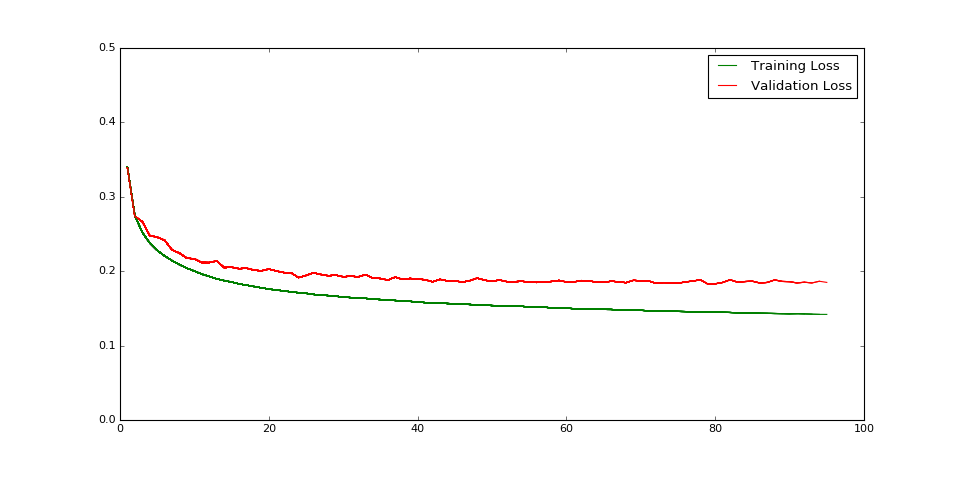

Epoch 1/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.3400

2017-03-27 17:32:58,939 : INFO : Found lower val loss for epoch 1 => 0.33934


254767/254767 [==============================] - 141s - loss: 0.3398 - val_loss: 0.3393
Epoch 2/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2747

2017-03-27 17:35:31,370 : INFO : Found lower val loss for epoch 2 => 0.27366


254767/254767 [==============================] - 152s - loss: 0.2747 - val_loss: 0.2737
Epoch 3/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2522

2017-03-27 17:38:05,487 : INFO : Found lower val loss for epoch 3 => 0.26662


254767/254767 [==============================] - 154s - loss: 0.2521 - val_loss: 0.2666
Epoch 4/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2379

2017-03-27 17:40:41,491 : INFO : Found lower val loss for epoch 4 => 0.24789


254767/254767 [==============================] - 156s - loss: 0.2378 - val_loss: 0.2479
Epoch 5/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2279

2017-03-27 17:43:18,012 : INFO : Found lower val loss for epoch 5 => 0.24573


254767/254767 [==============================] - 156s - loss: 0.2279 - val_loss: 0.2457
Epoch 6/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2205

2017-03-27 17:45:52,684 : INFO : Found lower val loss for epoch 6 => 0.24156


254767/254767 [==============================] - 154s - loss: 0.2205 - val_loss: 0.2416
Epoch 7/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2142

2017-03-27 17:48:27,781 : INFO : Found lower val loss for epoch 7 => 0.22862


254767/254767 [==============================] - 155s - loss: 0.2142 - val_loss: 0.2286
Epoch 8/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2087

2017-03-27 17:51:02,174 : INFO : Found lower val loss for epoch 8 => 0.22425


254767/254767 [==============================] - 154s - loss: 0.2087 - val_loss: 0.2243
Epoch 9/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2040

2017-03-27 17:53:35,980 : INFO : Found lower val loss for epoch 9 => 0.21747


254767/254767 [==============================] - 153s - loss: 0.2040 - val_loss: 0.2175
Epoch 10/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.2002

2017-03-27 17:56:10,454 : INFO : Found lower val loss for epoch 10 => 0.21663
2017-03-27 17:56:10,455 : INFO : Validation Loss Reduced 10 times
2017-03-27 17:56:10,456 : INFO : Evaluating on Validation Data
2017-03-27 17:57:12,141 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.688 | Top 3: 0.939 | Top 5: 0.989 | F1 Micro: 0.682 | F1 Macro: 0.613
254767/254767 [==============================] - 217s - loss: 0.2002 - val_loss: 0.2166
Epoch 11/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1960

2017-03-27 17:59:42,239 : INFO : Found lower val loss for epoch 11 => 0.21168


254767/254767 [==============================] - 148s - loss: 0.1960 - val_loss: 0.2117
Epoch 12/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1930

2017-03-27 18:02:11,651 : INFO : Found lower val loss for epoch 12 => 0.21163


254767/254767 [==============================] - 149s - loss: 0.1930 - val_loss: 0.2116
Epoch 13/200
254767/254767 [==============================] - 149s - loss: 0.1898 - val_loss: 0.2138
Epoch 14/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1874

2017-03-27 18:07:09,646 : INFO : Found lower val loss for epoch 14 => 0.20486


254767/254767 [==============================] - 148s - loss: 0.1874 - val_loss: 0.2049
Epoch 15/200
254767/254767 [==============================] - 149s - loss: 0.1854 - val_loss: 0.2053
Epoch 16/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1829

2017-03-27 18:12:09,010 : INFO : Found lower val loss for epoch 16 => 0.20338


254767/254767 [==============================] - 149s - loss: 0.1829 - val_loss: 0.2034
Epoch 17/200
254767/254767 [==============================] - 150s - loss: 0.1812 - val_loss: 0.2041
Epoch 18/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1794

2017-03-27 18:17:10,265 : INFO : Found lower val loss for epoch 18 => 0.20152


254767/254767 [==============================] - 151s - loss: 0.1794 - val_loss: 0.2015
Epoch 19/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1776

2017-03-27 18:19:39,129 : INFO : Found lower val loss for epoch 19 => 0.20045


254767/254767 [==============================] - 148s - loss: 0.1777 - val_loss: 0.2004
Epoch 20/200
254767/254767 [==============================] - 148s - loss: 0.1760 - val_loss: 0.2029
Epoch 21/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1747

2017-03-27 18:24:35,805 : INFO : Found lower val loss for epoch 21 => 0.20034


254767/254767 [==============================] - 148s - loss: 0.1747 - val_loss: 0.2003
Epoch 22/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1736

2017-03-27 18:27:04,408 : INFO : Found lower val loss for epoch 22 => 0.19821


254767/254767 [==============================] - 148s - loss: 0.1736 - val_loss: 0.1982
Epoch 23/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1722

2017-03-27 18:29:33,534 : INFO : Found lower val loss for epoch 23 => 0.19776


254767/254767 [==============================] - 149s - loss: 0.1722 - val_loss: 0.1978
Epoch 24/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1711

2017-03-27 18:32:01,758 : INFO : Found lower val loss for epoch 24 => 0.19142
2017-03-27 18:32:01,759 : INFO : Validation Loss Reduced 20 times
2017-03-27 18:32:01,760 : INFO : Evaluating on Validation Data
2017-03-27 18:33:02,598 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.570 | Top 3: 0.957 | Top 5: 0.993 | F1 Micro: 0.727 | F1 Macro: 0.660
254767/254767 [==============================] - 210s - loss: 0.1711 - val_loss: 0.1914
Epoch 25/200
254767/254767 [==============================] - 150s - loss: 0.1703 - val_loss: 0.1942
Epoch 26/200
254767/254767 [==============================] - 149s - loss: 0.1688 - val_loss: 0.1978
Epoch 27/200
254767/254767 [==============================] - 148s - loss: 0.1679 - val_loss: 0.1956
Epoch 28/200
254767/254767 [==============================] - 150s - loss: 0.1672 - val_loss: 0.1939
Epoch 29/200
254767/254767 [==============================] - 150s - loss: 0.1664 - val_loss: 0.1947
Epoch 30/200
254767/254767 [==============================] - 149s - loss: 0.1653 - val_loss: 0.1925
Epoch 31/200
254767/254767 [==============================] - 147s - loss: 0.1646 - val_loss: 0.1933
Epoch 32/200
254767/254767 [==============================] - 148s - loss: 0.1639 - val_loss: 0.1

2017-03-27 18:57:57,216 : INFO : Found lower val loss for epoch 34 => 0.19081


254767/254767 [==============================] - 148s - loss: 0.1624 - val_loss: 0.1908
Epoch 35/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1619

2017-03-27 19:00:26,562 : INFO : Found lower val loss for epoch 35 => 0.19016


254767/254767 [==============================] - 149s - loss: 0.1619 - val_loss: 0.1902
Epoch 36/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1613

2017-03-27 19:02:55,894 : INFO : Found lower val loss for epoch 36 => 0.18808


254767/254767 [==============================] - 149s - loss: 0.1612 - val_loss: 0.1881
Epoch 37/200
254767/254767 [==============================] - 148s - loss: 0.1606 - val_loss: 0.1921
Epoch 38/200
254767/254767 [==============================] - 148s - loss: 0.1599 - val_loss: 0.1890
Epoch 39/200
254767/254767 [==============================] - 149s - loss: 0.1594 - val_loss: 0.1903
Epoch 40/200
254767/254767 [==============================] - 149s - loss: 0.1587 - val_loss: 0.1893
Epoch 41/200
254767/254767 [==============================] - 149s - loss: 0.1578 - val_loss: 0.1886
Epoch 42/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1576

2017-03-27 19:17:51,020 : INFO : Found lower val loss for epoch 42 => 0.18571


254767/254767 [==============================] - 149s - loss: 0.1576 - val_loss: 0.1857
Epoch 43/200
254767/254767 [==============================] - 151s - loss: 0.1572 - val_loss: 0.1891
Epoch 44/200
254767/254767 [==============================] - 149s - loss: 0.1566 - val_loss: 0.1870
Epoch 45/200
254767/254767 [==============================] - 150s - loss: 0.1563 - val_loss: 0.1872
Epoch 46/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1556

2017-03-27 19:27:53,509 : INFO : Found lower val loss for epoch 46 => 0.18527


254767/254767 [==============================] - 150s - loss: 0.1556 - val_loss: 0.1853
Epoch 47/200
254767/254767 [==============================] - 149s - loss: 0.1553 - val_loss: 0.1873
Epoch 48/200
254767/254767 [==============================] - 152s - loss: 0.1548 - val_loss: 0.1907
Epoch 49/200
254767/254767 [==============================] - 163s - loss: 0.1544 - val_loss: 0.1880
Epoch 50/200
254767/254767 [==============================] - 168s - loss: 0.1538 - val_loss: 0.1862
Epoch 51/200
254767/254767 [==============================] - 166s - loss: 0.1538 - val_loss: 0.1882
Epoch 52/200
254767/254767 [==============================] - 166s - loss: 0.1531 - val_loss: 0.1859
Epoch 53/200
254767/254767 [==============================] - 165s - loss: 0.1527 - val_loss: 0.1859
Epoch 54/200
254767/254767 [==============================] - 167s - loss: 0.1528 - val_loss: 0.1864
Epoch 55/200
254767/254767 [==============================] - 166s - loss: 0.1520 - val_loss: 0.1855
Epo

2017-03-27 19:55:07,822 : INFO : Found lower val loss for epoch 56 => 0.18485


254767/254767 [==============================] - 166s - loss: 0.1518 - val_loss: 0.1849
Epoch 57/200
254767/254767 [==============================] - 166s - loss: 0.1517 - val_loss: 0.1854
Epoch 58/200
254767/254767 [==============================] - 160s - loss: 0.1507 - val_loss: 0.1862
Epoch 59/200
254767/254767 [==============================] - 151s - loss: 0.1510 - val_loss: 0.1876
Epoch 60/200
254767/254767 [==============================] - 147s - loss: 0.1503 - val_loss: 0.1855
Epoch 61/200
254767/254767 [==============================] - 147s - loss: 0.1496 - val_loss: 0.1856
Epoch 62/200
254767/254767 [==============================] - 147s - loss: 0.1495 - val_loss: 0.1874
Epoch 63/200
254767/254767 [==============================] - 159s - loss: 0.1492 - val_loss: 0.1867
Epoch 64/200
254767/254767 [==============================] - 184s - loss: 0.1489 - val_loss: 0.1856
Epoch 65/200
254767/254767 [==============================] - 182s - loss: 0.1486 - val_loss: 0.1849
Epo

2017-03-27 20:28:24,468 : INFO : Found lower val loss for epoch 68 => 0.18457


254767/254767 [==============================] - 185s - loss: 0.1478 - val_loss: 0.1846
Epoch 69/200
254767/254767 [==============================] - 181s - loss: 0.1473 - val_loss: 0.1877
Epoch 70/200
254767/254767 [==============================] - 184s - loss: 0.1474 - val_loss: 0.1871
Epoch 71/200
254767/254767 [==============================] - 166s - loss: 0.1469 - val_loss: 0.1871
Epoch 72/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1471

2017-03-27 20:39:46,788 : INFO : Found lower val loss for epoch 72 => 0.18378


254767/254767 [==============================] - 149s - loss: 0.1471 - val_loss: 0.1838
Epoch 73/200
254767/254767 [==============================] - 164s - loss: 0.1462 - val_loss: 0.1847
Epoch 74/200
254767/254767 [==============================] - 182s - loss: 0.1465 - val_loss: 0.1846
Epoch 75/200
254767/254767 [==============================] - 180s - loss: 0.1459 - val_loss: 0.1838
Epoch 76/200
254767/254767 [==============================] - 180s - loss: 0.1458 - val_loss: 0.1856
Epoch 77/200
254767/254767 [==============================] - 174s - loss: 0.1452 - val_loss: 0.1867
Epoch 78/200
254767/254767 [==============================] - 180s - loss: 0.1453 - val_loss: 0.1885
Epoch 79/200
253952/254767 [============================>.] - ETA: 0s - loss: 0.1453

2017-03-27 21:00:34,006 : INFO : Found lower val loss for epoch 79 => 0.18283


254767/254767 [==============================] - 183s - loss: 0.1454 - val_loss: 0.1828
Epoch 80/200
254767/254767 [==============================] - 182s - loss: 0.1449 - val_loss: 0.1831
Epoch 81/200
254767/254767 [==============================] - 182s - loss: 0.1448 - val_loss: 0.1849
Epoch 82/200
254767/254767 [==============================] - 181s - loss: 0.1445 - val_loss: 0.1885
Epoch 83/200
254767/254767 [==============================] - 181s - loss: 0.1441 - val_loss: 0.1853
Epoch 84/200
254767/254767 [==============================] - 181s - loss: 0.1438 - val_loss: 0.1861
Epoch 85/200
254767/254767 [==============================] - 168s - loss: 0.1438 - val_loss: 0.1865
Epoch 86/200
254767/254767 [==============================] - 151s - loss: 0.1435 - val_loss: 0.1841
Epoch 87/200
254767/254767 [==============================] - 148s - loss: 0.1433 - val_loss: 0.1849
Epoch 88/200
254767/254767 [==============================] - 148s - loss: 0.1431 - val_loss: 0.1883
Epo

2017-03-27 21:44:58,453 : INFO : Evaluating on Training Data
2017-03-27 21:51:13,194 : INFO : Generating Training Metrics


****** Training Metrics: Cov Err: 1.416 | Top 3: 0.982 | Top 5: 0.998 | F1 Micro: 0.861 | F1 Macro: 0.820


2017-03-27 21:51:19,514 : INFO : Evaluating on Validation Data using saved best weights
2017-03-27 21:52:50,093 : INFO : Generating Validation Metrics


****** Validation Metrics: Cov Err: 1.525 | Top 3: 0.962 | Top 5: 0.994 | F1 Micro: 0.746 | F1 Macro: 0.690


2017-03-27 21:52:52,066 : INFO : Loading Previous results from /mnt/data2/shalaby/nn_parameter_search_extended_abs_desc_claims_large_sample_chunks/doc2vec_size_200_w_2_type_dm_concat_0_mean_1_trainwords_0_hs_0_neg_10_vocabsize_None/epoch_8/lstm_sections_level_2_batch_1024_nn_parameter_searches.pkl


In [46]:
%matplotlib notebook

# random search for parameters
param_sampler = ParameterSampler({
    'lstm_output_size':lstm_output_sizes,
    'w_dropout':w_dropout_options,
    'u_dropout':u_dropout_options,
    'stack_layers':stack_layers_options,
    'conv_size':conv_size_options,
}, n_iter=NN_RANDOM_SEARCH_BUDGET, random_state=NN_PARAM_SAMPLE_SEED)

# load previous finshed results so we dont redo them
param_results_dict = {}
if load_existing_results:
    param_results_path = os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                       NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE)))
    if os.path.exists(param_results_path):
        info('Loading Previous results from {}'.format(param_results_path))
        param_results_dict = pickle.load(open(param_results_path))
    else:
        info('No Previous results exist in {}'.format(param_results_path))
        

# create nn parameter search directory
if not os.path.exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME)):
    os.makedirs(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))

# for every parameter set picked by random search, use it to train the model and output the metrics
for parameters in param_sampler:
    start_time = time.time()
    lstm_output_size = parameters['lstm_output_size']
    w_dropout_do = parameters['w_dropout']
    u_dropout_do = parameters['u_dropout']
    stack_layers = parameters['stack_layers']
    conv_size = parameters['conv_size']

    GLOBAL_VARS.NN_MODEL_NAME = 'lstm_optimizer_{}_size_{}_w-drop_{}_u-drop_{}_stack_{}_conv_{}'.format(NN_OPTIMIZER,
        lstm_output_size,  w_dropout_do, u_dropout_do, stack_layers, str(conv_size)
    )

    if GLOBAL_VARS.NN_MODEL_NAME in param_results_dict.keys() or GLOBAL_VARS.NN_MODEL_NAME in to_skip:
        print "skipping: {}".format(GLOBAL_VARS.NN_MODEL_NAME)
        continue

    info('***************************************************************************************')
    info(GLOBAL_VARS.NN_MODEL_NAME)

    # creating the actual keras model
    model = create_keras_rnn_model(DOC2VEC_SIZE, NN_OUTPUT_NEURONS, 
                                  lstm_output_size, w_dropout_do, u_dropout_do, stack_layers, conv_size)
    model.summary()

    # callbacks for early stopping and for generating validation metrics
    early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=EARLY_STOPPER_MIN_DELTA, \
                                                  patience=EARLY_STOPPER_PATIENCE, verbose=1, mode='auto')
    metrics_callback = MetricsCallback()


    # Model Fitting
    %time history = model.fit(x=X, y=y, validation_data=(Xv,yv), batch_size=NN_BATCH_SIZE, \
                              nb_epoch=NN_MAX_EPOCHS, verbose=MODEL_VERBOSITY, \
                              callbacks=[early_stopper, metrics_callback])
    
    time.sleep(0.2)
    info('Evaluating on Training Data')
    yp = model.predict(X) # get raw probability for predicted labels
    yp_binary = get_binary_0_5(yp) # use 0.5 as threshold for setting labels to 0 or 1
    #print yvp
    info('Generating Training Metrics')
    training_metrics = get_metrics(y, yp, yp_binary)
    print "****** Training Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
    training_metrics['coverage_error'], training_metrics['top_3'], training_metrics['top_5'], 
    training_metrics['f1_micro'], training_metrics['f1_macro'])
    
    
    time.sleep(0.2)
    info('Evaluating on Validation Data using saved best weights')
    model.set_weights(metrics_callback.best_weights)
    yvp = model.predict(Xv) # get raw probability for predicted labels
    yvp_binary = get_binary_0_5(yvp) # use 0.5 as threshold for setting labels to 0 or 1
    #print yvp
    info('Generating Validation Metrics')
    validation_metrics = get_metrics(yv, yvp, yvp_binary)
    print "****** Validation Metrics: Cov Err: {:.3f} | Top 3: {:.3f} | Top 5: {:.3f} | F1 Micro: {:.3f} | F1 Macro: {:.3f}".format(
        validation_metrics['coverage_error'], validation_metrics['top_3'], validation_metrics['top_5'], 
        validation_metrics['f1_micro'], validation_metrics['f1_macro'])
    best_validation_metrics = validation_metrics
    
    time.sleep(0.2)
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME] = dict()
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_validation_metrics'] = best_validation_metrics
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['epochs'] = len(history.history['val_loss'])
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_weights'] = metrics_callback.best_weights
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['best_val_loss'] = metrics_callback.best_val_loss
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['training_loss'] = metrics_callback.losses
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['validation_loss'] = metrics_callback.val_losses

    duration = time.time() - start_time
    param_results_dict[GLOBAL_VARS.NN_MODEL_NAME]['duration'] =  duration

    del history, metrics_callback, model

if save_results:
    if load_existing_results:
        if os.path.exists(param_results_path):
            info('Loading Previous results from {}'.format(param_results_path))
            loaded_param_results_dict = pickle.load(open(param_results_path))
            param_results_dict.update(loaded_param_results_dict)
            
    pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                                   NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE))), 'w'))

In [50]:
param_results_dict.keys()

['lstm_optimizer_rmsprop_size_200_w-drop_0.4_u-drop_0.2',
 'lstm_optimizer_adam_size_300_w-drop_0.2_u-drop_0.3',
 'lstm_optimizer_adam_size_200_w-drop_0.3_u-drop_0.2',
 'lstm_optimizer_adam_size_200_w-drop_0.2_u-drop_0.3',
 'lstm_optimizer_adam_size_200_w-drop_0.2_u-drop_0.2',
 'lstm_optimizer_rmsprop_size_200_w-drop_0.2_u-drop_0.4']

In [ ]:
if load_existing_results:
    if os.path.exists(param_results_path):
        info('Loading Previous results from {}'.format(param_results_path))
        loaded_param_results_dict = pickle.load(open(param_results_path))
        param_results_dict.update(loaded_param_results_dict)

    pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                                   NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE))), 'w'))

In [60]:
pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                                   NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, PARTS_LEVEL, NN_BATCH_SIZE))), 'w'))

In [58]:
%xdel model
import gc
for i in range(3): gc.collect()

In [51]:
pickle.dump(param_results_dict, open(os.path.join(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME, 
                                                                   NN_PARAMETER_SEARCH_PREFIX.format(classifications_type, NN_BATCH_SIZE))), 'w'))

In [52]:
    # create nn parameter search directory
    if not os.path.exists(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME)):
        os.makedirs(os.path.join(nn_parameter_search_location, GLOBAL_VARS.MODEL_NAME))
        